In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh
# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [ ]:
# reload(sdh)

In [29]:
reload(nn)
import relembed as nn

In [3]:
# reload(eh)
import experiment_helper as eh

In [4]:
shuffle_seed = 10

In [5]:
# reload(dh)
DH = dh.DataHandler('data/semeval_train_sdp_8000', valid_percent=10, shuffle_seed=shuffle_seed) # for semeval

Creating Data objects...
Done creating Data objects
7999 total examples :: 7199 training : 800 valid (90:10 split)
Vocab size: 22683 Dep size: 50


In [6]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(shuffle_seed=shuffle_seed)
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7199
Num valididation: 800
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [7]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

In [8]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 13


In [9]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM

19423 / 22683 pretrained


In [37]:
config = {
    'max_num_steps':DH.max_seq_len,
    'word_embed_size':300,
    'dep_embed_size':25,
    'vocab_size':DH.vocab_size,
    'dep_vocab_size':DH.dep_size,
    'num_predict_classes':num_classes,
    'pretrained_word_embeddings':word_embeddings,
    'max_grad_norm':3.,
    'model_name':'relembed_semeval_alt',
    'checkpoint_prefix':'checkpoints/',
    'summary_prefix':'tensor_summaries/'
}
try:
    tf.reset_default_graph()
except:
    pass
try:
    tf.get_default_session().close()
except:
    pass
drnn = nn.RelEmbed(config)
print(drnn)

<DPNN: W:300, D:25, H:600, V:22683>


In [33]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index]
    padded_qp = np.zeros([DH.max_seq_len, 2]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]    
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, valid_phrases, valid_lens)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [34]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

# Unsupervised Training

In [ ]:
# hyperparameters
num_epochs = 1
batch_size =50
neg_per = 25
num_nearby = 50
nearby_mod = 50
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for epoch in range(num_epochs):
    offset = 0 #if epoch else 400
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per)):
        if not step: step = offset
        t0 = time()
        loss = drnn.partial_unsup_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
            ml,sl = divmod(left, 60)
            hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                  % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_loss = drnn.validation_loss(*DH.validation_batch())
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()

In [ ]:
drnn.checkpoint()

In [ ]:
# # test the embeddings

# ### VALID ###
# # valid_phrases, valid_targets, _, valid_lens = DH.validation_batch()
# # phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(valid_phrases, valid_targets, valid_lens)
# # phrase_labels, target_labels = DH.readable_data(valid=True)

# ### TRAIN ###
# train_phrases, train_targets, _, train_lens = DH.batches(500, neg_per=0, offset=0).next()
# phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(train_phrases, train_targets, train_lens)
# phrase_labels, target_labels = DH.readable_data(show_dep=False, valid=False)
        
# phrase_embeds /= np.sqrt(np.sum(phrase_embeds**2, 1, keepdims=True))
# target_embeds /= np.sqrt(np.sum(target_embeds**2, 1, keepdims=True))

In [ ]:
# ### JOINT ###
# start = 0
# stride = 40
# end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# joint_embeds = np.vstack([phrase_embeds[start:end], target_embeds[start:end]])
# joint_2d = lowd.fit_transform(joint_embeds)
# phrase_2d, target_2d = joint_2d[:stride], joint_2d[stride:]

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(phrase_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = phrase_2d[i,:]
#     ax.scatter(x, y, color='b')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')
# for i, label in enumerate(target_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = target_2d[i,:]
#     ax.scatter(x, y, color='r')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
# ### PHRASE ONLY ###
# start = 0
# stride = 50
# end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# phrase_2d = lowd.fit_transform(phrase_embeds[start:end])

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(phrase_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = phrase_2d[i,:]
#     ax.scatter(x, y, color='b')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
# ### TARGET ONLY ###
# start = 0
# stride = 35
# end = start + stride

# lowd = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# target_2d = lowd.fit_transform(target_embeds[start:end])

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(target_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = target_2d[i,:]
#     ax.scatter(x, y, color='r')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
### TW2V demo ###
start = 200
stride = 100
end = start + stride

lowd = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
# lowd = PCA(n_components=2)

target_2d = lowd.fit_transform(word_embeddings[start:end])

fig, ax = plt.subplots(figsize=(28,16))
for i, label in enumerate(DH.vocab[start:end]):
    label = "%s" % (label)
    x, y = target_2d[i,:]
    ax.scatter(x, y, color='b')
    ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    
plt.savefig('word2vec_demo.png', dpi=200)

# Test out semeval data

In [11]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [12]:
for i, (raw, _, sdp, target, label) in enumerate(zip_train):
    if i > 5:
        break
    print(raw)
    print("%s :: %s" % (DH.sequence_to_sentence(sdp, show_dep=True), DH.sequence_to_sentence(target)))
    print(int2label[label])
    print("="*80)


4046	"The <e1>grief</e1> from sudden <e2>death</e2> is completely different from expected death, when families have time to prepare and say goodbye."

(<X>, nsubj) (from, prep) (<Y>, pobj) :: grief death
Cause-Effect(e2,e1)
5297	"The author examines some <e1>issues</e1> connected to religious <e2>freedom</e2>."

(<X>, dobj) (connected, acl) (to, prep) (<Y>, pobj) :: issues freedom
Other
5275	"The <e1>lawsuit</e1> alleged the release of the records was a <e2>violation</e2> of the Video Privacy Protection Act."

(<X>, nsubj) (alleged, ROOT) (was, ccomp) (<Y>, attr) :: lawsuit violation
Message-Topic(e1,e2)
6524	"This movie has thrown <e1>viewers</e1> into <e2>confusion</e2>."

(<X>, dobj) (thrown, ROOT) (into, prep) (<Y>, pobj) :: viewers confusion
Other
5981	"The <e1>windshield</e1> encloses a parachute <e2>housing</e2> containing a parachute assembly."

(<X>, nsubj) (encloses, ROOT) (<Y>, dobj) :: windshield housing
Content-Container(e2,e1)
3699	"Hand-stitched with fabric and <e1>cloth

# Supervised Training

In [13]:
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 25
display_mod = 10
valid_mod = 50
print("Num steps %i" %num_steps)

start = time()
for epoch in range(num_epochs):
    random.shuffle(zip_train) # shuffling should only happen once per epoch
    _, _, sdps, targets, labels = zip(*zip_train)
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, sdps, targets, labels, 
                                              offset=step, shuffle=False)
        xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, xent))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
            valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
            print("="*80)
            print("Saving model...")
            drnn.checkpoint()
    label_set = set(train['labels'])
    preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
    cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
    print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
drnn.checkpoint()
print("Done")

Num steps 143
(0:0:0) s 0/143, e 0 avg class xent loss = 2.8962
(0:0:1) s 0/143, e 0 validation avg class xent loss = 3.4929
Saving model...
(0:0:10) s 10/143, e 0 avg class xent loss = 7.1094
(0:0:14) s 20/143, e 0 avg class xent loss = 2.6630
(0:0:18) s 30/143, e 0 avg class xent loss = 1.7560
(0:0:23) s 40/143, e 0 avg class xent loss = 1.6003
(0:0:27) s 50/143, e 0 avg class xent loss = 1.4235
(0:0:28) s 50/143, e 0 validation avg class xent loss = 1.3049
Saving model...
(0:0:36) s 60/143, e 0 avg class xent loss = 1.7017
(0:0:40) s 70/143, e 0 avg class xent loss = 1.6060
(0:0:44) s 80/143, e 0 avg class xent loss = 1.7397
(0:0:48) s 90/143, e 0 avg class xent loss = 1.8282
(0:0:52) s 100/143, e 0 avg class xent loss = 1.8551
(0:0:53) s 100/143, e 0 validation avg class xent loss = 1.1334
Saving model...
(0:1:1) s 110/143, e 0 avg class xent loss = 1.4979
(0:1:5) s 120/143, e 0 avg class xent loss = 1.8244
(0:1:9) s 130/143, e 0 avg class xent loss = 1.2009
(0:1:13) s 140/143, e 0

KeyboardInterrupt: 

# Alternating

In [38]:
results = []
#timing stuff
start = time()
fit_time = 0
nearby_time = 0

batch_size = 50
num_cycles = 20
num_epochs = 3
num_class_epochs = 5
display_mod = 10
valid_mod = 50

# hyperparameters

neg_per = 2
neg_level = 2
num_nearby = 20
nearby_mod = 100
sample_power = .75
DH.scale_vocab_dist(sample_power)

# # bookkeeping
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

    
for cycle in range(num_cycles):
    print("+"*80)
    print("+++ CYCLE %i +++" % cycle)
    print("+"*80)

    epoch = 0
    class_epoch = 0
    
    num_steps = DH.num_steps(batch_size)


    for epoch in range(num_epochs):
        print("="*80)
        print("=== UNSUP EPOCH %i ===" % epoch)
        print("="*80)
        offset = 0 #if epoch else 400
        DH.shuffle_data()
        for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per, neg_level=neg_level)):
            if not step: step = offset
            t0 = time()
            loss = drnn.partial_unsup_fit(*batch)
            fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
            if step % display_mod == 0:
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
                ml,sl = divmod(left, 60)
                hl,ml = divmod(ml, 60)
                pps = batch_size*(neg_per + 1) / fit_time 
                print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                      % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
            if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
                t0 = time()
                run_validation_test(num_nearby) # check out the nearby phrases in the validation set
                valid_loss = drnn.validation_loss(*DH.validation_batch())
                print("Validation loss: %0.4f" % valid_loss)
                nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
            total_step +=1
        valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
        label_set = set(train['labels'])
        preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
        cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
        print("Saving model...")
        model_file = drnn.checkpoint()
        result = {'cycle':cycle, 'unsup_epoch':epoch, 'class_epoch':class_epoch, 
              'cm':cm, 'stats':stats, 'macro_f1':stats['macro_f1'], 'model':model_file}
        results.append(result)
        print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))

    num_steps = len(train['labels']) // batch_size

    for class_epoch in range(num_class_epochs):
    #     class_batch = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], offset=0)
    #     random.shuffle(class_batch)
        print("*"*80)
        print("*** CLASS EPOCH %i ***" % class_epoch)
        print("*"*80)
        for class_step in range(num_steps):
            inputs, targets, labels, lens = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], offset=class_step)
            class_batch = zip(inputs, targets, labels, lens)
            random.shuffle(class_batch)
            class_batch = zip(*class_batch)
            xent = drnn.partial_class_fit(*class_batch)
            if class_step % display_mod == 0:   
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, class_step, num_steps, class_epoch, xent))
            if class_step % valid_mod == 0:
                valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
                valid_xent = drnn.validation_class_loss(*valid_batch)
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print("="*80)
                print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, class_step, num_steps, class_epoch, valid_xent))
                print("="*80)
                
        label_set = set(train['labels'])
        preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3])
        cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
        print("Saving model...")
        model_file = drnn.checkpoint()
        result = {'cycle':cycle, 'unsup_epoch':epoch, 'class_epoch':class_epoch, 
              'cm':cm, 'stats':stats, 'macro_f1':stats['macro_f1'], 'model':model_file}
        results.append(result)
        print("Macro P: %2.4f, R: %3.4f, F1: %0.4f" % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    print("Done")
best = sorted(results, key=lambda x:x['macro_f1'], reverse=True)[0]
print("Best result %2.4f, C:%i, UE:%i, CE:%i" % 
      (best['macro_f1'], best['cycle'], best['unsup_epoch'], best['class_epoch']))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++ CYCLE 0 +++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
=== UNSUP EPOCH 0 ===
(0:0:1) step 0/143, epoch 0 Training Loss = 788.79602 :: 272.378 phrases/sec :: (0:2:36) hours left
Top 20 closest phrases to <magazine> '<X> informs about <Y>' <science>
0: 1.000 : <magazine> '<X> informs about <Y>' <science>
1: 0.998 : <excerpt> '<X> speaking about <Y>' <times>
2: 0.998 : <allegations> '<X> made about <Y>' <behaviour>
3: 0.998 : <example> '<X> was about <Y>' <functions>
4: 0.997 : <book> '<X> in explains <Y>' <graduate>
5: 0.997 : <quote> '<X> is from <Y>' <interview>
6: 0.997 : <taste> '<X> is from <Y>' <ginseng>
7: 0.996 : <chapter> '<X> is around <Y>' <themes>
8: 0.996 : <tradition> '<X> narrated in <Y>' <biographies>
9: 0.996 : <plans> '<X> outlined for <Y>' <farm>
10: 0.996 : <argumentation> '<X> relating with <Y>' <speed>
11: 0.996 : <santur> '<X> made with <Y>' <b

In [39]:
print(best['model'])

checkpoints/relembed_semeval_alt.ckpt-286-286


In [14]:
# write out the training and validation keys for our split
with open('SemEval2010_task8_all_data/train_keys.txt', 'w') as f:
    i = 1
    for label in train['labels']:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1
with open('SemEval2010_task8_all_data/valid_keys.txt', 'w') as f:
    i = len(train['labels'])
    for label in valid['labels']:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1

In [15]:
# check out training predictions
valid_batch = DH.classification_batch(len(train['labels']), train['sdps'], train['targets'], train['labels'])

# valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], shuffle=False)
preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3], return_probs=False)
# write out to file and get official score
with open('SemEval2010_task8_all_data/train_preds.txt', 'w') as f:
    i = 1
    for label in preds:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1


pred shape: (7199,)


In [16]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/train_preds.txt SemEval2010_task8_all_data/train_keys.txt;

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 309    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  309    0  309
 C-E2 |   0  598    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  598    0  598
 C-W1 |   0    0  430    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  430    0  430
 C-W2 |   0    0    0  426    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  426    0  426
 C-C1 |   0    0    0    0  338    0    0    0    0    0    0    0    0    0    0    0    0    0    0 |  338    0  338
 C-C2 |   0    0    0    0    0  148    0    0    0    0    0    0    0    0    0    0   

Use of uninitialized value in subtraction (-) at ./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl line 288.
Use of uninitialized value in printf at ./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl line 288.


In [17]:
# check out validation predictions
# valid_batch = DH.classification_batch(len(train['labels']), train['sdps'], train['targets'], train['labels'])

valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], shuffle=False)
preds = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[3], return_probs=False)
# write out to file and get official score
with open('SemEval2010_task8_all_data/valid_preds.txt', 'w') as f:
    i = len(train['labels'])
    for label in preds:
        f.write("%s\t%s\n" % (i, int2label[label]))
        i += 1


pred shape: (800,)


In [18]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/valid_preds.txt SemEval2010_task8_all_data/valid_keys.txt;

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 |  31    0    0    0    0    0    0    1    0    0    0    0    0    0    0    1    1    1 |   35    0   35
 C-E2 |   0   51    0    0    0    0    0    2    0    0    2    0    0    0    0    1    0    5 |   61    0   61
 C-W1 |   0    0   30    1    0    0    0    0    0    0    0    0    3    0    0    0    1    5 |   40    0   40
 C-W2 |   0    0    1   33    0    0    0    0    1    0    1    0    2    1    0    0    1    5 |   45    0   45
 C-C1 |   0    0    0    0   31    0    4    0    0    0    0    0    0    0    0    0    0    1 |   36    0   36
 C-C2 |   0    0    1    3    0   12    0    0    0    0    0    0    1    0    0    0    0    1 |   18    0   18
 E-D1 |   

experiment_helper.py:136: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


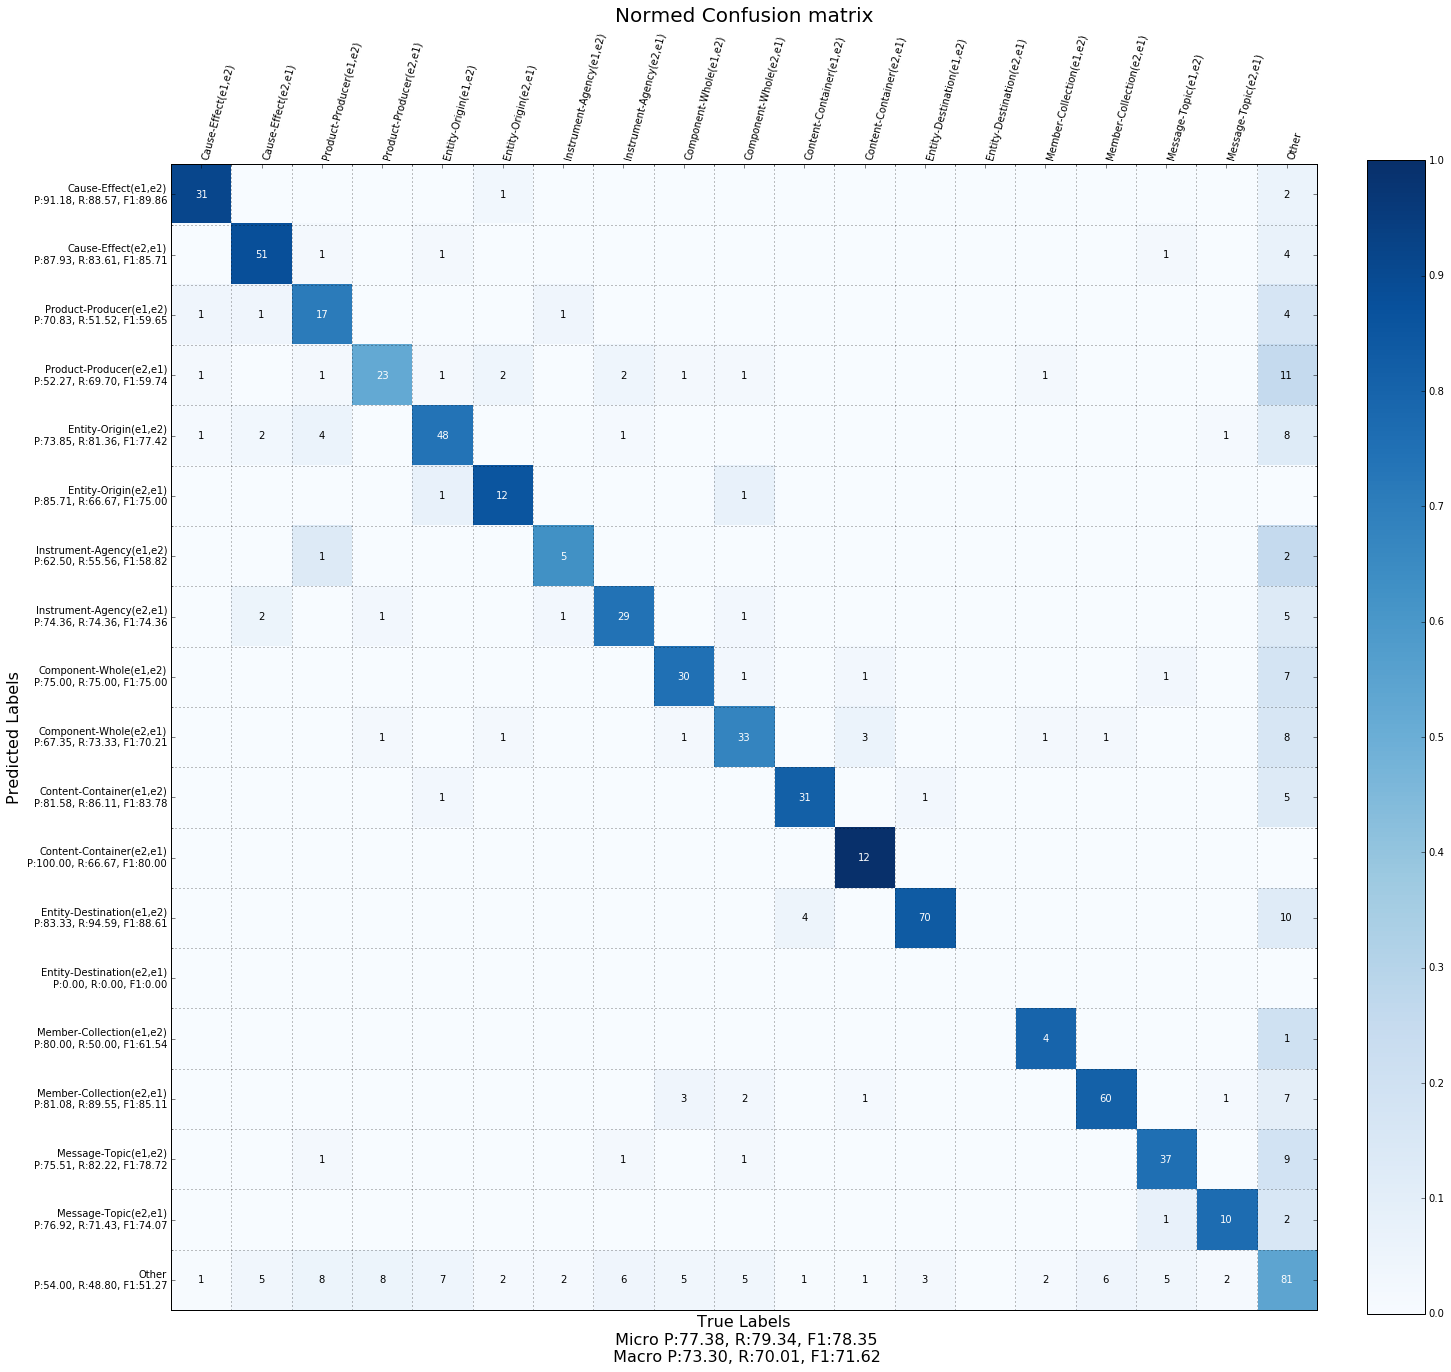

In [19]:
# save_name = raw_input("Enter save name: ")
save_name = ''
cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set, no_other=True)
eh.plot_confusion_matrix(cm, int2label.values(), save_name=save_name, stats=stats)

In [20]:
# write out predictions for test set
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False)
preds = drnn.predict(test_batch[0], test_batch[1], test_batch[3])
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

pred shape: (2717,)


In [21]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 120    4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    4    6 |  134    0  134
 C-E2 |   1  174    0    1    0    0    0    0    4    0    0    0    0    0    0    0    2    0   12 |  194    0  194
 C-W1 |   0    0  121    3    2    1    1    0    0    0    3    1    2   10    2    0    2    0   14 |  162    0  162
 C-W2 |   0    0    7  107    0    0    0    0    1    0    0    6    0    3    3    0    0    4   19 |  150    0  150
 C-C1 |   0    0    2    0  129    0    9    0    3    0    0    0    0    0    0    1    0    0    9 |  153    0  153
 C-C2 |   0    0    0    2    0   30    0    0    0    1    0    0    0    2    1    0   

In [ ]:
# for i, p in enumerate(preds):
#     print("%i, pred: %s, true: %s" %(i, int2label[p], int2label[valid['labels'][i]]))
#     taarget = DH.sequence_to_sentence(valid['targets'][i]).split(' ')
#     sdp = DH.sequence_to_sentence(valid['sdps'][i], show_dep=True)
#     print('<%s> "%s" <%s>' % (target[0], sdp, target[1]))
#     print(valid['raws'][i])
#     print(valid['comments'][i])
#     print("="*80)

### Directional Evaluation

In [ ]:
# save_name = raw_input("Enter save name: ")
save_name = ''
cm, stats = eh.confusion_matrix(preds, valid['labels'], label_set)
eh.plot_confusion_matrix(cm, int2label.values(), save_name=save_name, stats=stats)

### Non Directional evaluation

In [ ]:
bi_preds, bi_int2label, bi_label2int = eh.directional_to_bidirectional_labels(preds, int2label)
bi_labels, _, _ = eh.directional_to_bidirectional_labels(valid['labels'], int2label)
bi_labelset = set(bi_int2label.keys())
print(bi_label2int)

In [ ]:
# save_name = raw_input("Enter save name: ")
bi_cm, bi_stats = eh.confusion_matrix(bi_preds, bi_labels, bi_labelset)
eh.plot_confusion_matrix(bi_cm, bi_int2label.values(), save_name=save_name, stats=stats)

In [ ]:
random.seed(42)
random.shuffle([0,1,2])